In [72]:
import numpy as np
import matplotlib.pyplot as plt
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import grad, dot, laplacian, ddot

In [2]:
def graficar_navier_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')


    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True)
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

def graficar_laplaciano(mesh, lap_u_x, lap_u_y, lap_p):

    plt.figure(figsize=(8,6))
    scatter_ux = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_x, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_ux, label='$\\Delta u_x$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_x$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de u_y
    plt.figure(figsize=(8,6))
    scatter_uy = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_y, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_uy, label='$\\Delta u_y$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_y$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de la presión
    plt.figure(figsize=(8,6))
    scatter_p = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_p, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_p, label='$\\Delta p$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta p$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

### Caso 1: 
Usando P=0 en un punto


In [25]:
# Definir dominio y mallado
nx, ny = 12, 12
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

In [26]:
# Asignar ID a las fronteras
mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

In [27]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N = Nu + Np

In [75]:
# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)         

# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    wx, wy = w['w'][0], w['w'][1]                
    return wx * dot(grad(u)[0], v) + wy * dot(grad(u)[1], v)

# @BilinearForm
# def convection(u, v, w):
#     ux, uy = u[0], u[1]
#     wx, wy = w['w'][0], w['w'][1]
#     print(wx.shape)
#     print(wy.shape)
#     print(u.shape)
#     print(v.shape)     
#     # grad_u = grad(u)
#     # return dot(w, grad(u)[:,0, : ,:])*v[0] + dot(w, grad(u)[:,1, :, :])*v[1]
#     # pass

#     return wx * dot(grad(u)[0], v) + wy * dot(grad(u)[1], v)

@BilinearForm
def convection(u, v, w):
    # w['w'] es la velocidad conocida (campo vectorial)
    advection_field = w['w']
    
    # grad(u) es el tensor gradiente de la velocidad trial
    grad_u = grad(u)
    
    # La operación es: w_j * (d u_i / d x_j) * v_i
    # j...  -> índice de w y de la derivada (contracción)
    # ij... -> índices del gradiente (componente i, derivada j)
    # i...  -> índice de v (componente i)
    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)

# @BilinearForm
# def convection_skew(u, v, w):
#     wx, wy = w['w'][0], w['w'][1]
#     term1 = wx * dot(grad(u)[0], v) + wy * dot(grad(u)[1], v)   # (w*nabla)u*v
#     term2 = wx * dot(grad(v)[0], u) + wy * dot(grad(v)[1], u)   # (w*nabla)v*u
#     return 0.5 * (term1 - term2)

In [76]:
# Perfiles exacto
nu = 1.0

def u_exact_x(x, y):
    return x*0 + y**2

def u_exact_y(x, y):
    return x**2 + y*0

def p_exact_xy(x, y):
    return 1 + 0*x + 0*y

def f_exact_x(x, y):
    return -nu*2 + 2* (x**2) * y

def f_exact_y(x, y):
    return  -nu*2 + 2 *x* (y**2)

In [77]:
x_boundary = np.zeros(Nu + Np)

# Fronteras de la velocidad

# Obtener DOFs de las fronteras de la base de velocidad
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

# Elementos con condiciones de Dirichlet para la velocidad
# Impares y, pares x
y_left   = basis_u.doflocs[1, dofs_left[1::2]] 
y_right  = basis_u.doflocs[1, dofs_right[1::2]]

x_left   = basis_u.doflocs[0, dofs_left[::2]]  
x_right  = basis_u.doflocs[0, dofs_right[::2]]

x_top    = basis_u.doflocs[0, dofs_top[::2]]
x_bottom = basis_u.doflocs[0, dofs_bottom[::2]]

y_top    = basis_u.doflocs[1, dofs_top[1::2]]
y_bottom = basis_u.doflocs[1, dofs_bottom[1::2]]


x_boundary[dofs_left[::2]]    =  u_exact_x(x_left, y_left)  # componente x
x_boundary[dofs_left[1::2]]   =  u_exact_y(x_left, y_left)  # componente y

x_boundary[dofs_right[::2]]   =  u_exact_x(x_right, y_right)  # componente x
x_boundary[dofs_right[1::2]]  =  u_exact_y(x_right, y_right)  # componente y

x_boundary[dofs_top[::2]]     =  u_exact_x(x_top, y_top)  # componente x
x_boundary[dofs_top[1::2]]    =  u_exact_y(x_top, y_top)  # componente y

x_boundary[dofs_bottom[::2]]  =  u_exact_x(x_bottom, y_bottom)  # componente x
x_boundary[dofs_bottom[1::2]] =  u_exact_y(x_bottom, y_bottom)  # componente y

dofs_u_boundary = np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom
])

x_boundary[Nu + 0]  = p_exact_xy(0.0, 0.0)  # Fijar presión en un punto para unicidad
dofs_p_boundary = np.array([Nu+0])# + np.concatenate([np.array([0])])

D_all = np.unique(np.concatenate([dofs_u_boundary, dofs_p_boundary]))

In [78]:
@LinearForm
def rhs_u(v, w):
    x, y = w.x
    fx = f_exact_x(x, y)
    fy = f_exact_y(x, y)
    return fx * v[0] + fy * v[1]

b_u = asm(rhs_u, basis_u) 
b_p = np.zeros(Np)  
F   = np.concatenate([b_u, b_p])

In [79]:
def solve_ns_picard(u_init, p_init, Re, max_iter, tol):
    u = u_init
    p = p_init
    for it in range(max_iter):
        # Campo de advección congelado w := u^(it) en puntos de cuadratura
        W = basis_u.interpolate(u)   

        # Ensambla bloque convectivo C(w)
        C = asm(convection, basis_u, w=W)

        # Matriz bloque del paso linealizado
        K = bmat([[(1/Re) * A + C, B.T ],
                  [B,              None]], format='csr')

        # Resolver
        sol = solve(*condense(K, F, D=D_all, x=x_boundary))
        u_new = sol[:Nu]
        p_new = sol[Nu:Nu+Np]

        # Criterio de convergencia
        du = u_new - u
        rel_u = np.linalg.norm(du) / (np.linalg.norm(u_new) + 1e-16)

        dp = p_new - p
        rel_p = np.linalg.norm(dp) / (np.linalg.norm(p_new) + 1e-16)

        # # Sub-relajación si se desea
        u = u_new
        p = p_new

        if rel_u < tol and rel_p < tol:
            print(f"Convergió en {it+1} iteraciones, residuo {max(rel_u, rel_p):.4e}")
            return u, p, True
    print("No convergió en el número máximo de iteraciones")
    return u, p, False

In [80]:
mu = 1.0

# Calcular solución inicial de stokes
K_stokes = bmat([[mu * A,     B.T],  
                 [B,         None]], format='csr')

sol0 = solve(*condense(K_stokes, F, D=D_all, x=x_boundary))
u_ref = sol0[:Nu].copy()*0
p_ref = sol0[Nu:Nu+Np].copy()

In [81]:
# Resolver incrementanto Re
Re = 1
Re_linspace = np.linspace(1, Re, 1)

for R in Re_linspace:
    print(f"Resolviendo para Re = {R:.2f}")
    u_ref, p_ref, flag = solve_ns_picard(u_ref, p_ref, R, max_iter=500, tol=1e-12)

    if not flag:
        print(f"No se pudo converger para este Re = {R:.2f}.")
        break

u_sol = u_ref
p_sol = p_ref


Resolviendo para Re = 1.00
Convergió en 7 iteraciones, residuo 2.6815e-13


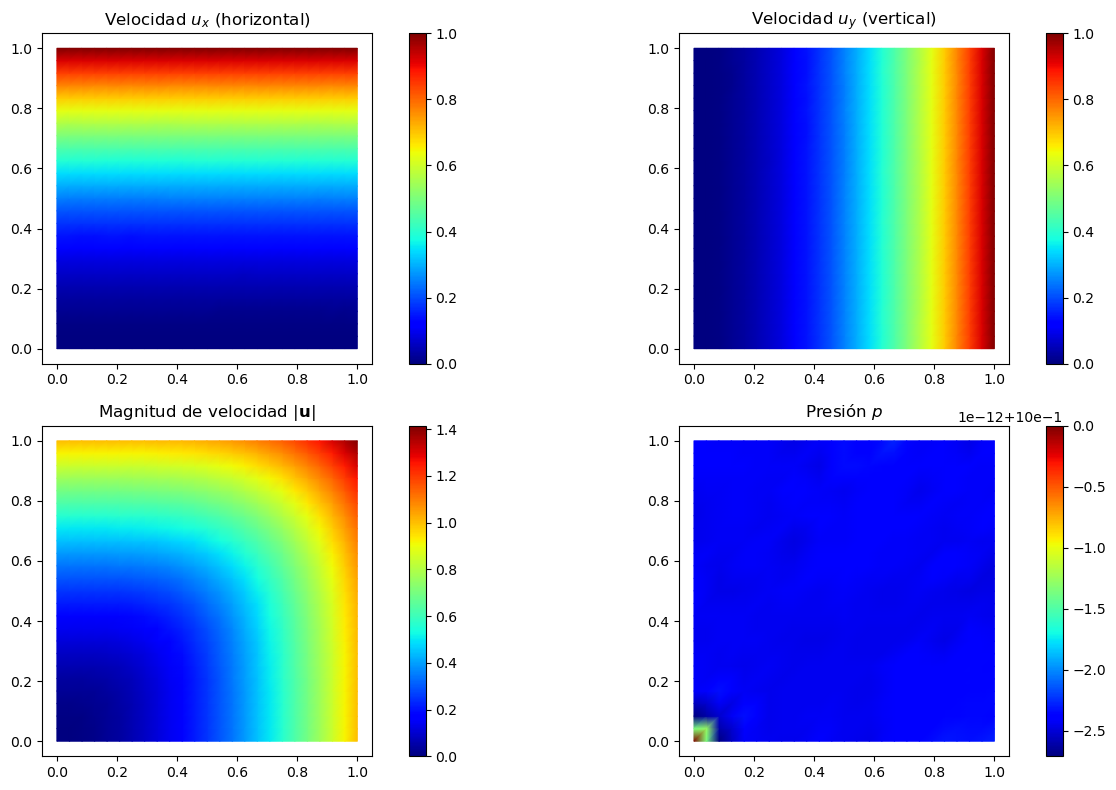

In [82]:
graficar_navier_stokes(u_sol, p_sol, mesh, basis_p, basis_u)

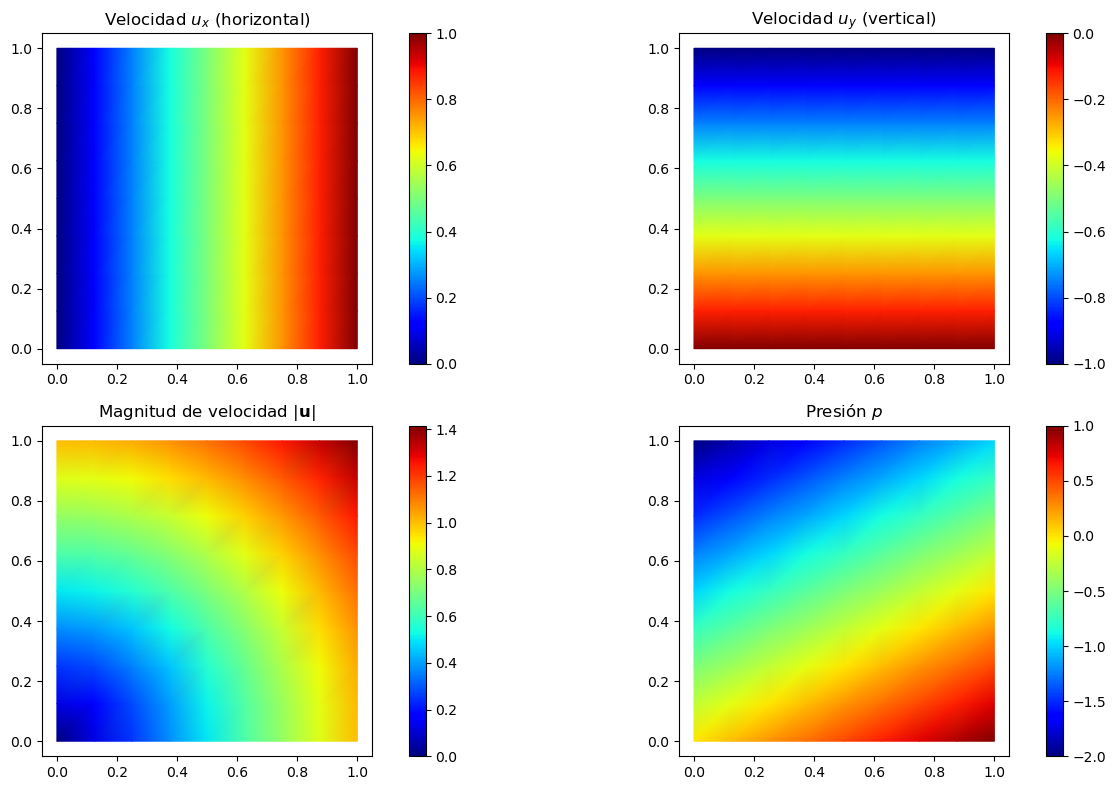

In [186]:
# Construir solucion exacta velocidad
def construir_u_exacta(basis_u):
    Nu = basis_u.N
    u_sol = np.zeros(Nu)

    x_u = basis_u.doflocs[0]  # coordenadas x de todos los DOFs de velocidad
    y_u = basis_u.doflocs[1]  # coordenadas y de todos los DOFs de velocidad

    # DOFs pares: componente x de la velocidad
    u_sol[0::2] = u_exact_x(x_u[0::2], y_u[0::2])
    # DOFs impares: componente y de la velocidad
    u_sol[1::2] = u_exact_y(x_u[1::2], y_u[1::2])

    return u_sol

# Construir solucion exacta presion
def construir_p_exacta(basis_p):
    Np = basis_p.N
    p_sol = np.zeros(Np)

    x_p = basis_p.doflocs[0]  # coordenadas x de los DOFs de presion
    y_p = basis_p.doflocs[1]  # coordenadas y de los DOFs de presion

    p_sol[:] = p_exact_xy(x_p, y_p)

    return p_sol

# Construir y graficar
u_sol = construir_u_exacta(basis_u)
p_sol = construir_p_exacta(basis_p)

graficar_navier_stokes(u_sol, p_sol, mesh, basis_p, basis_u)


In [169]:
# Velocidades
u_x = u_sol[0::2]  # componente x
u_y = u_sol[1::2]  # componente y

base_u1 = Basis(mesh, ElementTriP2(), intorder=4)
lap_u_x = laplacian(u_x, base_u1)
lap_u_y = laplacian(u_y, base_u1)

# Presion
base_p1 = Basis(mesh, ElementTriP1(), intorder=4)
lap_p = laplacian(p_sol, base_p1)

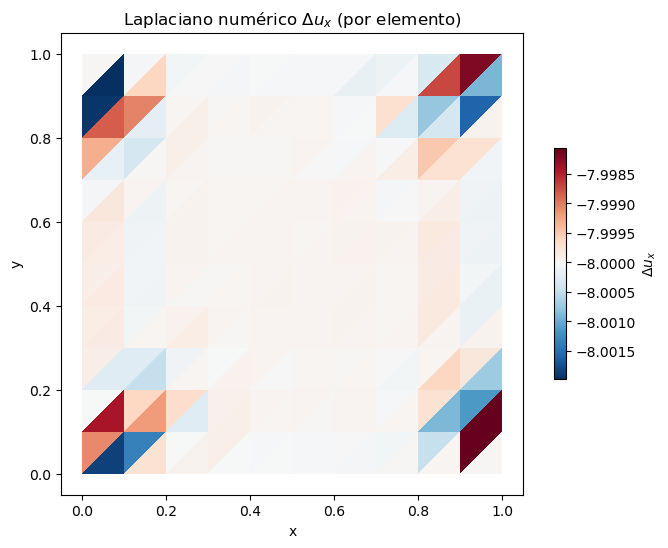

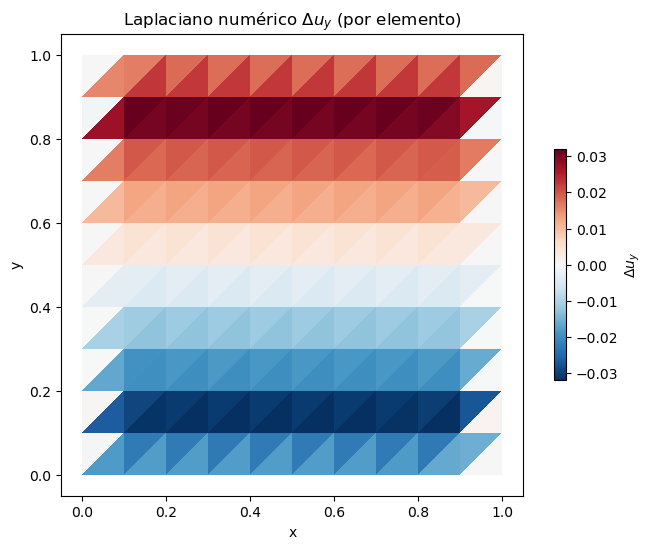

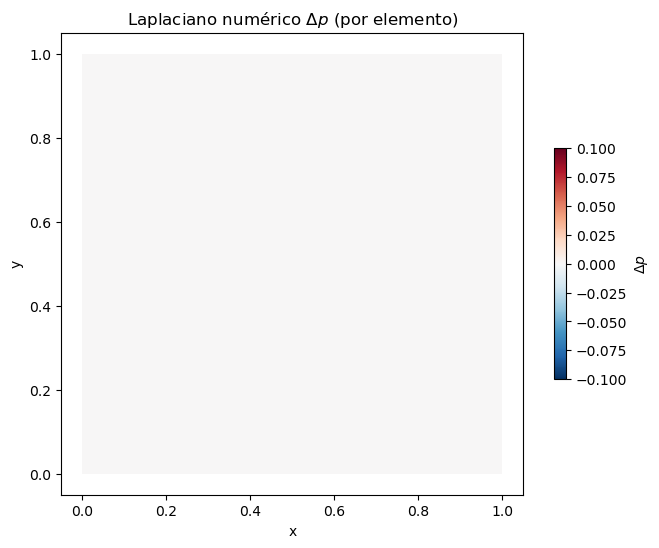

In [170]:
graficar_laplaciano(mesh, lap_u_x, lap_u_y, lap_p)

### Caso 2: 
Usando integral de la presión igual a cero.

In [181]:
# Definir dominio y mallado
nx, ny = 10, 10
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

In [182]:
# Asignar ID a las fronteras
mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

In [183]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N = Nu + Np

In [188]:
# Ensamblaje de matrices
A = asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)         

# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    wx, wy = w['w'][0], w['w'][1]                
    return wx * dot(grad(u)[0], v) + wy * dot(grad(u)[1], v)

@BilinearForm
def convection_skew(u, v, w):
    wx, wy = w['w'][0], w['w'][1]
    term1 = wx * dot(grad(u)[0], v) + wy * dot(grad(u)[1], v)   # (w*nabla)u*v
    term2 = wx * dot(grad(v)[0], u) + wy * dot(grad(v)[1], u)   # (w*nabla)v*u
    return 0.5 * (term1 - term2)

@LinearForm
def mean_vec(q, w):
    return q

m = asm(mean_vec, basis_p)    # shape: (Np,)
Mcol = m.reshape((-1, 1))     # (Np,1)
Mrow = m.reshape((1,  -1))    # (1,Np)

# Vector de términos fuente (cero)
F_u = basis['u'].zeros()
F_p = basis['p'].zeros()
F = np.hstack([F_u, F_p])
F_aug = np.hstack([F, 0.0])   


In [200]:
# Perfil 
def u_in_x(x, y):
    V_max = 1.0
    return V_max * 4.0 * y * (1.0 - y) + 0*x

def u_in_y(x, y):
    return  0*x + 0*y

# Obtener DOFs de las fronteras
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

# Elementos con condiciones de Dirichlet
# Impares y, pares x
y_left   = basis_u.doflocs[1, dofs_left[1::2]] 
y_right  = basis_u.doflocs[1, dofs_right[1::2]]

x_left   = basis_u.doflocs[0, dofs_left[::2]]  
x_right  = basis_u.doflocs[0, dofs_right[::2]]

x_top    = basis_u.doflocs[0, dofs_top[::2]]
x_bottom = basis_u.doflocs[0, dofs_bottom[::2]]

y_top    = basis_u.doflocs[1, dofs_top[1::2]]
y_bottom = basis_u.doflocs[1, dofs_bottom[1::2]]

x_boundary = np.zeros(Nu + Np + 1)

x_boundary[dofs_left[::2]]    =  u_in_x(x_left, y_left)  # componente x
x_boundary[dofs_left[1::2]]   =  u_in_y(x_left, y_left)  # componente y

x_boundary[dofs_right[::2]]    =  u_in_x(x_right, y_right)  # componente x
x_boundary[dofs_right[1::2]]   =  u_in_y(x_right, y_right)  # componente y

x_boundary[dofs_top]     =  0.0  # componente x e y
x_boundary[dofs_bottom]  =  0.0  # componente x e y

D_all = np.unique(np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom,
]))

In [212]:
# Método de Picard
nu    = .1         # viscosidad
rho   = .1
maxit = 1000
tol   = 1e-14
theta = 1.0        

# Inicialización: toma la solución de Stokes como punto de partida (w=0 ⇒ C=0)
K_stokes = bmat([
        [nu * A,     B.T,  None],   # (Nu, Nu) (Nu, Np) (Nu, 1)
        [B,          None, Mcol],   # (Np, Nu) (Np, Np) (Np, 1)
        [None,       Mrow, None],   # (1,  Nu) (1,  Np) (1,  1)
    ], format='csr')

sol0 = solve(*condense(K_stokes, F_aug, D=D_all, x=x_boundary))
u = sol0[:Nu].copy()
p = sol0[Nu:Nu+Np].copy()

for it in range(maxit):
    # Campo de advección congelado w := u^(it) en puntos de cuadratura
    W = basis_u.interpolate(u)   

    # Ensambla bloque convectivo C(w)
    C = asm(convection, basis_u, w=W)

    # Matriz bloque del paso linealizado
    K = bmat([
        [nu * A + rho * C, B.T,  None],
        [B,                None, Mcol],
        [None,             Mrow, None],
    ], format='csr')

    # Resolver con condensación de las CC (incluye x_bound)
    sol = solve(*condense(K, F_aug, D=D_all, x=x_boundary))
    u_new = sol[:Nu]
    p_new = sol[Nu:Nu+Np]

    # Criterio de convergencia (corrección relativa en u)
    du = u_new - u
    rel = np.linalg.norm(du) / (np.linalg.norm(u_new) + 1e-16)

    # # Sub-relajación
    u = (1.0 - theta) * u + theta * u_new
    p = (1.0 - theta) * p + theta * p_new

    if rel < tol:
        print(f"Convergió en {it+1} iteraciones, residuo {rel:.2e}")
        break

# Solución final
u_sol, p_sol = u, p

Convergió en 5 iteraciones, residuo 5.83e-16


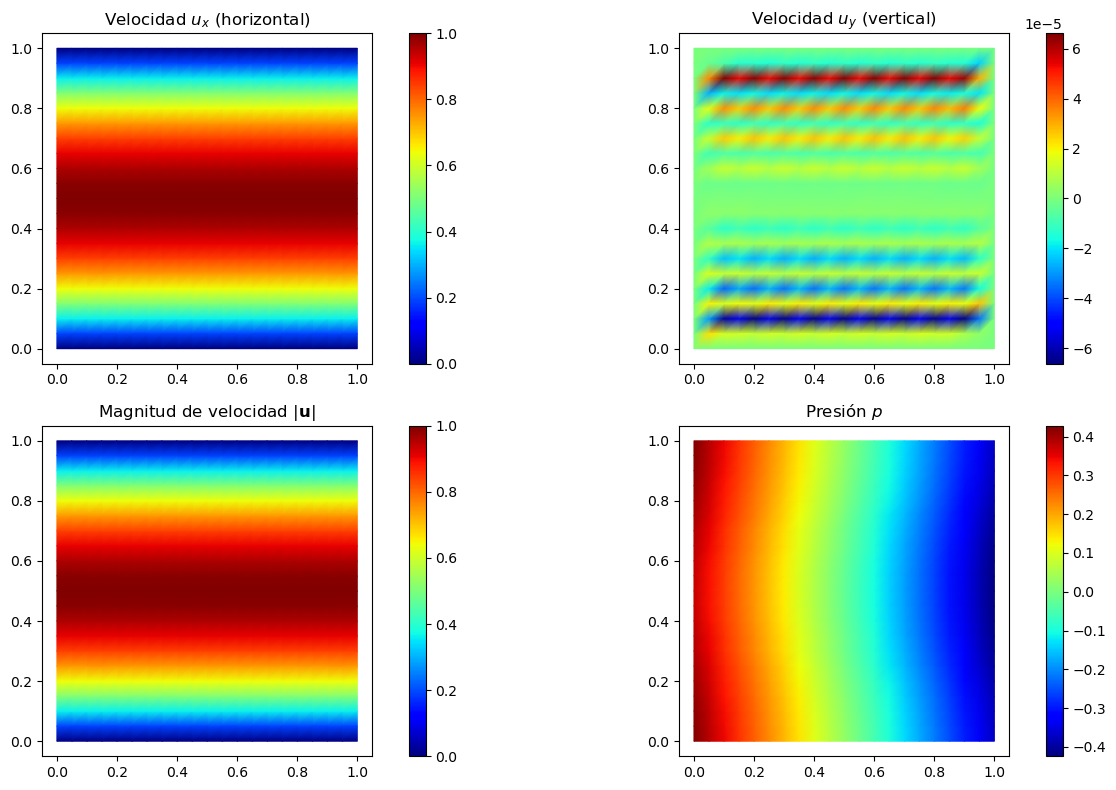

In [213]:
graficar_navier_stokes(u_sol, p_sol, mesh, basis_p, basis_u)